Imports

In [73]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

Adding label to each dataset

In [74]:
files = ["Industrivarden_vanlig2", "Investor", "Latour"]

dataframes = []

for f in files: 
    f_path = "data/"+f+"_binned.csv"
    dataframe = pd.read_csv(f_path)
    dataframe['label'] = np.where(dataframe['RETURN - OMXS'] > 0, 1, 0)
    dataframe = dataframe.dropna()
    dataframe.to_csv(f_path)
    dataframes.append(dataframe)


Chaching categorical labels into numerical values and shifting the data to look at the return for the previous day

In [101]:

df = pd.read_csv("data/label.csv")
mapping = {"low": 0, "medium": 1, "high": 2}

df['RETURN - OMXS_CAT'] = df['RETURN - OMXS_CAT'].map(mapping) 
df['DISCOUNT/PREMIUM_ADJ_CAT'] = df['DISCOUNT/PREMIUM_ADJ_CAT'].map(mapping)


for col in df.columns:
    if col not in ['DATE', 'RETURN - OMXS', 'Unnamed: 0', 'DATUM']:
        df[col] = df[col].shift(1)


df = df.iloc[1:].reset_index(drop=True)
print(df.head)

<bound method NDFrame.head of       Unnamed: 0.1  Unnamed: 0        DATE  PRICE  CALCULATED_NAV  \
0             20.0          21  2016-12-28  169.0           194.0   
1             21.0          22  2016-12-29  168.8           193.0   
2             22.0          23  2016-12-30  168.3           191.0   
3             23.0          24  2017-01-02  169.8           192.0   
4             24.0          25  2017-01-03  170.1           193.0   
...            ...         ...         ...    ...             ...   
6018        6078.0        2023  2024-12-04  282.4           216.0   
6019        6079.0        2024  2024-12-05  286.1           218.0   
6020        6080.0        2025  2024-12-06  285.0           217.0   
6021        6081.0        2026  2024-12-09  287.2           218.0   
6022        6082.0        2027  2024-12-10  284.3           219.0   

      INDEX_VALUE  RETURN_OMXS  DISCOUNT/PREMIUM    RETURN  RETURN - OMXS  \
0     1533.310703         7.26          0.147929  0.250888      

Splitting the data into training and testing

In [148]:
drop_x = ['label', 'DATE', 'RETURN - OMXS', 'RETURN - OMXS_CAT', 'Unnamed: 0.1',
          'Unnamed: 0', 'RETURN']

X = df.drop(columns=drop_x)
Y = df['label']


x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.20)


print(len(x_train))
print(len(x_test))


4818
1205


Distrubution across labels

In [149]:
length = len(Y)

proportions = Y.value_counts(normalize=True)
print(proportions)

label
1.0    0.700481
0.0    0.299519
Name: proportion, dtype: float64


All columns used for training

In [150]:
print(x_train.iloc[4])
models = []

PRICE                        107.500000
CALCULATED_NAV                97.000000
INDEX_VALUE                 1628.543612
RETURN_OMXS                   -6.250000
DISCOUNT/PREMIUM              -0.097674
DISCOUNT/PREMIUM_ADJ           0.108247
DISCOUNT/PREMIUM_NORM          0.645941
DAILY_RETURN                  -0.004630
VOL_30D                        0.160789
SHARPE_30D                     3.210088
VOL_EXP                        0.139732
SHARPE_EXP                     3.205539
DISCOUNT/PREMIUM_ADJ_CAT       0.000000
Name: 4139, dtype: float64


Classification models

Randomforrest

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

rf= RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(x_train, y_train)

models.append({'name': 'RandomForestClassifier', 'model': rf})

y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_true=y_test, y_pred=y_pred)

print(f"Accuracy for the Random Forest Classifier: {accuracy:.4f}")
print(f"F1 for Random Forest Classifier: {f1:.4f}")

Accuracy for the Random Forest Classifier: 0.9718
F1 for Random Forest Classifier: 0.9800


Visualisation

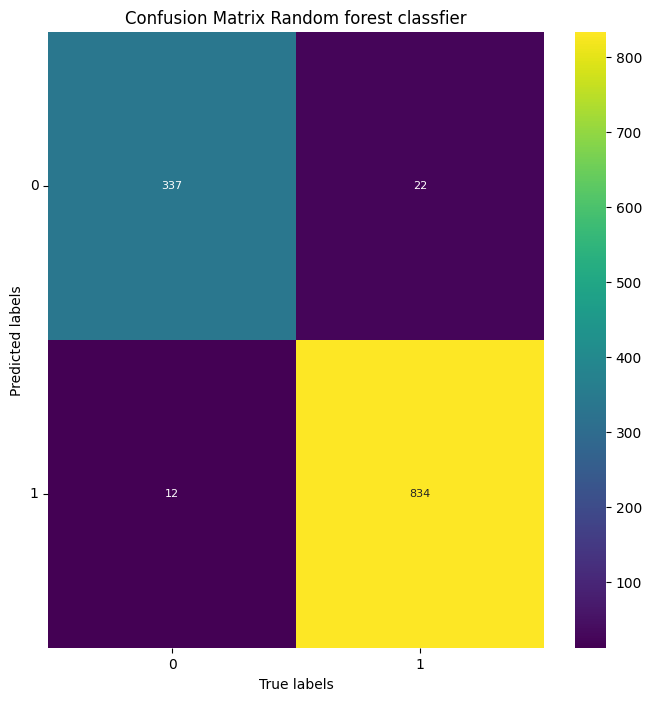

In [152]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix Random forest classfier') 
plt.yticks(rotation=0)
plt.show()

SVM classifcation

In [153]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)

svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)

print(f'The accuracy for the SVM classfier {accuracy:.4f}')

f1 = f1_score(y_true=y_test, y_pred=y_pred)


print(f"F1 for SVM Classifier: {f1:.4f}")

models.append ({'name':'SVM', 'model':svm})

# default rbf: 0.7024:  
# Linear kernel 0.9668
# poly 0.7434
# sigmoid 0.7179


The accuracy for the SVM classfier 0.8191
F1 for SVM Classifier: 0.8734


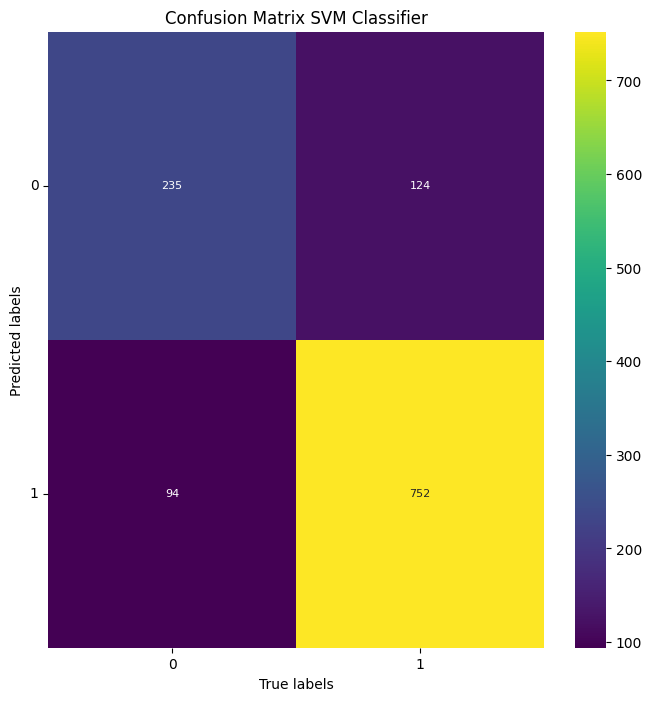

In [154]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix SVM Classifier') 
plt.yticks(rotation=0)
plt.show()

Decision tree classifier

In [155]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=42)

decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)

models.append({'name':'Decision Trees', 'model':decision_tree})

print(f'The accuracy for the Decision tree classfier {accuracy:.4f}')
f1 = f1_score(y_true=y_test, y_pred=y_pred)

print(f"F1 for Decision tree Classifier: {f1:.4f}")

#gini 9790
# Entropy 0.9746

The accuracy for the Decision tree classfier 0.9577
F1 for Decision tree Classifier: 0.9698


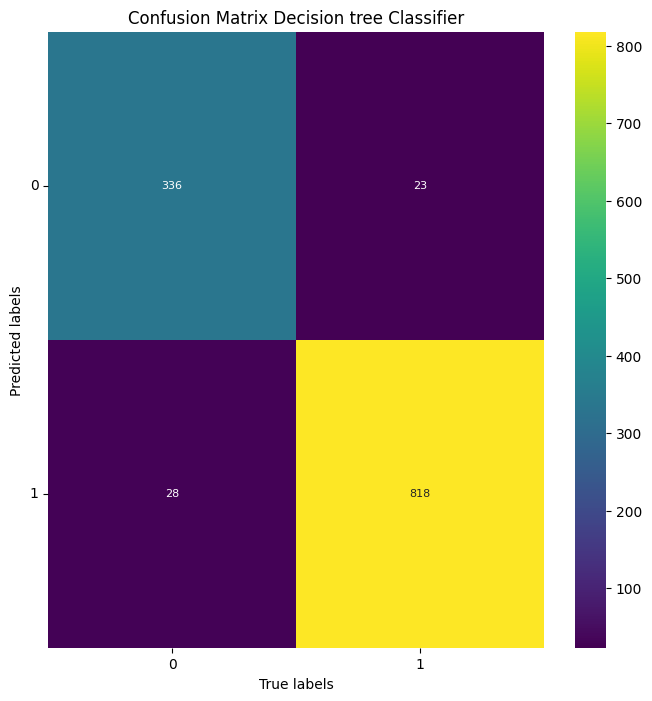

In [156]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix Decision tree Classifier') 
plt.yticks(rotation=0)
plt.show()

Logistic regression

In [157]:
from sklearn.linear_model import LogisticRegression

logistic_regregression = LogisticRegression(penalty="l2", solver="saga", max_iter=10000, random_state=42)

logistic_regregression.fit(x_train, y_train)

y_pred = logistic_regregression.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)


models.append({'name':'Logitsic Regression', 'model':logistic_regregression})

print(f'The accuracy for Logistic regression is: {accuracy:.4f}')

f1 = f1_score(y_true=y_test, y_pred=y_pred)

print(f"F1 for Logistic regression: {f1:.4f}")

The accuracy for Logistic regression is: 0.8041
F1 for Logistic regression: 0.8695


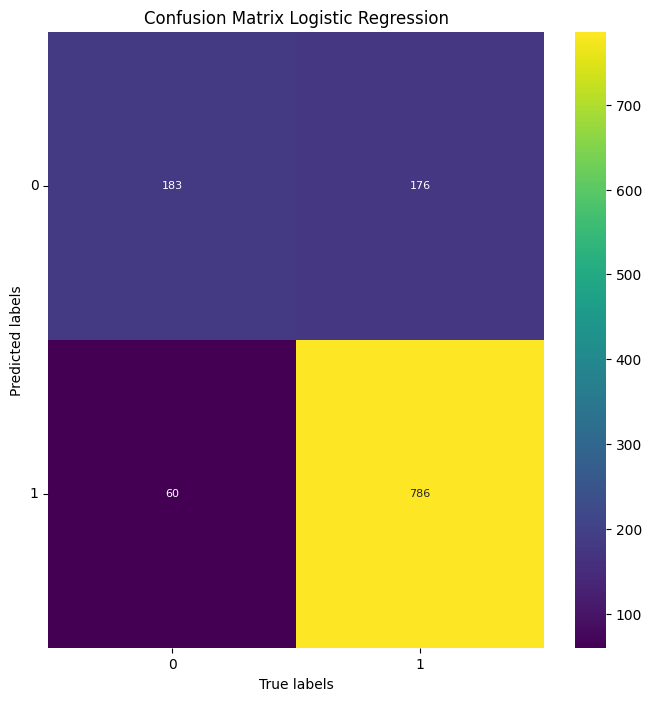

In [158]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix Logistic Regression') 
plt.yticks(rotation=0)
plt.show()

K-nearest neighbor

In [159]:
from sklearn.neighbors import KNeighborsClassifier

nearest_neighbour = KNeighborsClassifier(n_neighbors=1)

nearest_neighbour.fit(x_train, y_train)

y_pred = nearest_neighbour.predict(x_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)


models.append({'name':'K-nearest neighbor', 'model':nearest_neighbour})

print(f'The accuracy for K nearest neighbour classifier is: {accuracy:.4f}')

f1 = f1_score(y_true=y_test, y_pred=y_pred)

print(f"F1 for K nearest neighbour classifier: {f1:.4f}")

The accuracy for K nearest neighbour classifier is: 0.9485
F1 for K nearest neighbour classifier: 0.9632


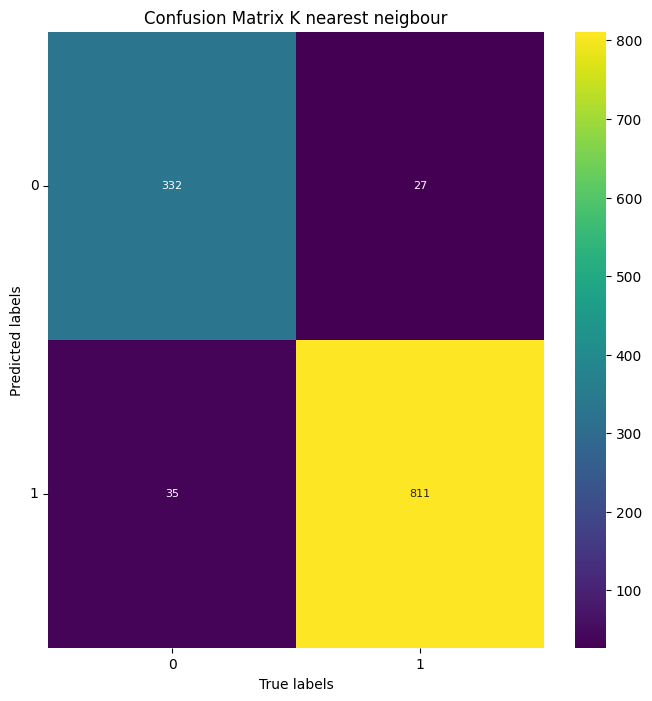

In [160]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix K nearest neigbour') 
plt.yticks(rotation=0)
plt.show()

K-means

In [161]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)

kmeans.fit(x_train, y_train)

y_pred = kmeans.predict(x_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

models.append({'name':'K-means', 'model':kmeans})

print(f'The accuracy for K Means is: {accuracy:.4f}')
f1 = f1_score(y_true=y_test, y_pred=y_pred)

print(f"F1 for K Means is: {f1:.4f}")


The accuracy for K Means is: 0.5983
F1 for K Means is: 0.7372


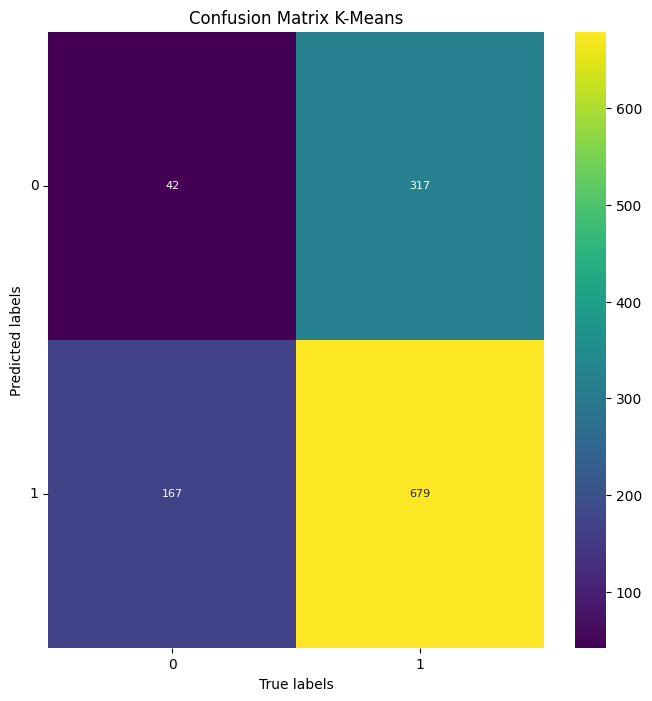

In [162]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fig, ax = plt.subplots(figsize=(8,8)) 

sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={'size': 8}, cmap='viridis')

ax.set_xlabel('True labels') 
ax.set_ylabel('Predicted labels')
ax.set_title('Confusion Matrix K-Means') 
plt.yticks(rotation=0)
plt.show()

Simulation

In [163]:
drop_x_no_label = ['DATE', 'RETURN - OMXS',
          'Unnamed: 0', 'DATUM', 'Unnamed: 0.1']

#Loading in dataframes
Omxs30 = pd.read_csv('test_data/OMXS30.csv')
Investor_original = pd.read_csv('test_data/full_inve_b_test_preprocess_binned.csv')
Industrivarlden_original = pd.read_csv('test_data/full_indu_c_test_preprocess_binned.csv')
Latour_original = pd.read_csv('test_data/full_lato_b_test_preprocess_binned.csv')

#Mapping the categorical values
mapping = {"low": 0, "medium": 1, "high": 2}
Investor_original['DISCOUNT/PREMIUM_ADJ_CAT'] = Investor_original['DISCOUNT/PREMIUM_ADJ_CAT'].map(mapping) 
Industrivarlden_original['DISCOUNT/PREMIUM_ADJ_CAT'] = Industrivarlden_original['DISCOUNT/PREMIUM_ADJ_CAT'].map(mapping) 
Latour_original['DISCOUNT/PREMIUM_ADJ_CAT'] = Latour_original['DISCOUNT/PREMIUM_ADJ_CAT'].map(mapping) 



# Specifying cut off for simulation
cut_off = "2024-12-10"
Investor_original = Investor_original[Investor_original['DATE'] > cut_off]
Industrivarlden_original = Industrivarlden_original[Industrivarlden_original['DATE'] > cut_off]
Latour_original = Latour_original[Latour_original['DATE'] > cut_off]
Omxs30 = Omxs30[Omxs30['Date'] > cut_off]



# Shifting the test data
feature_cols = [col for col in Investor_original.columns if col not in ['DATE', 'RETURN - OMXS', 'Unnamed: 0', 'DATUM']]
Investor_original[feature_cols] = Investor_original[feature_cols].shift(1)
Investor_original = Investor_original.iloc[1:].reset_index(drop=True)

Industrivarlden_original[feature_cols] = Industrivarlden_original[feature_cols].shift(1)
Industrivarlden_original = Industrivarlden_original.iloc[1:].reset_index(drop=True)

Latour_original[feature_cols] = Latour_original[feature_cols].shift(1)
Latour_original = Latour_original.iloc[1:].reset_index(drop=True)

Omx_feature_columns = [col for col in Omxs30.columns if col not in['Date']]
Omxs30 = Omxs30[Omx_feature_columns].shift(1)
Omxs30 = Omxs30.iloc[1:].reset_index(drop=True)


Investor = Investor_original.drop(columns=drop_x_no_label)
Industrivarlden = Industrivarlden_original.drop(columns=drop_x_no_label)
Latour = Latour_original.drop(columns=drop_x_no_label)


#Initialising variables
rows = len(Investor)
amount = 10000
balance_omx = amount

# Investor, Industrivärlden, Latour
balances = [amount, amount, amount]



for m in models: 
    name = m['name']
    model = m['model']
    
    for i in range(rows):
        row_omx = Omxs30.iloc[i]

        firms = []
        firms.append(Investor.iloc[[i]])
        firms.append( Industrivarlden.iloc[[i]])
        firms.append(Latour.iloc[[i]])


        j = 0
        for firm in firms:
        
            
            invetsment_balance = balances[j]
            difference = invetsment_balance * return_omx
            return_firm = firms[j].iloc[0]['DAILY_RETURN'] 

            firm_no_return = firm.drop(columns=['RETURN'])
            index_value = firms[j].iloc[0]['INDEX_VALUE'] 
            return_omxs = firms[j].iloc[0]['RETURN_OMXS'] 


            firm_no_return['INDEX_VALUE'] = return_omxs
            firm_no_return['RETURN_OMXS'] = index_value

            firm_no_return = firm_no_return.rename(columns={
                    'INDEX_VALUE': 'RETURN_OMXS',
                    'RETURN_OMXS': 'INDEX_VALUE'
                })


            prediction = model.predict(firm_no_return)
            

            if prediction[0] == 0:
                #Buy OMXS30 instead
                return_omx = row_omx['Avkastning OMXS#=']
                difference = invetsment_balance * return_omx
                gain = invetsment_balance + difference
                balances[j] = gain

            else:
                # Continue in the firm
                difference = invetsment_balance * return_firm
                gain = invetsment_balance + difference
                balances[j] = gain
            j = j + 1
                



    balance_investor = balances[0]
    balance_industrivarlden = balances[1]
    balance_lator = balances[2]


    ####################################
    print(75 * '*')
    print()
    print(f'After simulation the last {rows} trading days investing {amount}')
    print(f'This is a simulation uses {name}')
    print()
    print(f'The return from Investor is: {balance_investor}')
    print(f'The return from Industri världen is: {balance_industrivarlden}')
    print(f'The return from Latour is: {balance_lator}')
    print()
    print(75 * '*')

    #Reseting for the next model
    balances = [amount, amount, amount]


    # For comparasion
def calculate_buy_and_hold(df, initial_amount):
    balance = initial_amount
    for daily_return in df['DAILY_RETURN']:
        balance = balance + balance * daily_return
    return balance

baseline_investor = calculate_buy_and_hold(Investor_original, amount)
baseline_industri = calculate_buy_and_hold(Industrivarlden_original, amount)
baseline_latour = calculate_buy_and_hold(Latour_original, amount)

baseline_omxs = amount
for daily_return in Omxs30['Avkastning OMXS#=']:
    baseline_omxs = baseline_omxs * (1 + daily_return)

print(f"\n{'='*75}")
print("BASELINE: BUY AND HOLD (No Trading Strategy)")
print(f"{'='*75}")
print(f"OMXS30 buy-and-hold:           {baseline_omxs:2f}")
print(f"Investor buy-and-hold:         {baseline_investor:2f}")
print(f"Industrivärden buy-and-hold:   {baseline_industri:2f}")
print(f"Latour buy-and-hold:           {baseline_latour:2f}")
print(f"{'='*75}\n")

***************************************************************************

After simulation the last 240 trading days investing 10000
This is a simulation uses RandomForestClassifier

The return from Investor is: 10656.765676567678
The return from Industri världen is: 10403.178183865912
The return from Latour is: 7689.208688770817

***************************************************************************
***************************************************************************

After simulation the last 240 trading days investing 10000
This is a simulation uses SVM

The return from Investor is: 10797.557253511595
The return from Industri världen is: 10876.764386536357
The return from Latour is: 8194.787240159712

***************************************************************************
***************************************************************************

After simulation the last 240 trading days investing 10000
This is a simulation uses Decision Trees

The return from I